# Hypothese 1

In [53]:
import os

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from matplotlib.patches import Patch

import settings

## Daten einlesen

In [80]:
OpenAlex_Anzahl_Paper_Zeitraum = pd.read_csv("data/input/OpenAlex_Anzahl_Paper_Zeitraum.csv")
OpenAlex_Anzahl_Paper_Zeitraum

,Jahr,Anzahl_Paper
0,2000,531528
1,2001,551318
2,2002,662708
3,2003,674234
4,2004,711148
5,2005,766324
6,2006,853541
7,2007,888980
8,2008,958262
9,2009,1029663


In [ ]:
Eurostat_Investitionen = pd.read_csv("data/input/Eurostat_Investitionen.csv")
Eurostat_Investitionen.sort_values(by="Jahr", ascending=False).head(27)

,Land,Jahr,Betrag in Mio. Euro
287,Frankreich,2023,61725.558
47,Belgien,2023,19817.608
599,Schweden,2023,19481.687
335,Ungarn,2023,2726.054
263,Finnland,2023,8439.400
359,Irland,2023,8072.043
239,Spanien,2023,22379.154
383,Italien,2023,27939.070
215,Griechenland,2023,3362.682
407,Litauen,2023,772.435


In [56]:
os.makedirs('data/output', exist_ok=True)

## Investition vs. Output

In [57]:
# Daten vorbereiten
jahressummen = Eurostat_Investitionen.groupby('Jahr')['Betrag in Mio. Euro'].sum().reset_index()

jahressummen['Investitionen_Mrd'] = jahressummen['Betrag in Mio. Euro'] / 1000  # Mio. → Mrd.
df = pd.merge(OpenAlex_Anzahl_Paper_Zeitraum, jahressummen[['Jahr', 'Investitionen_Mrd']], on='Jahr', how='inner')

# Daten auf 2023 begrenzen, weil 2024 nicht vollständig ist
df = df[df['Jahr'] <= 2023]
df = df.sort_values('Jahr')

print(f"Zeitraum: {df['Jahr'].min():.0f}-{df['Jahr'].max():.0f}, {len(df)} Jahre")

Zeitraum: 2000-2023, 24 Jahre


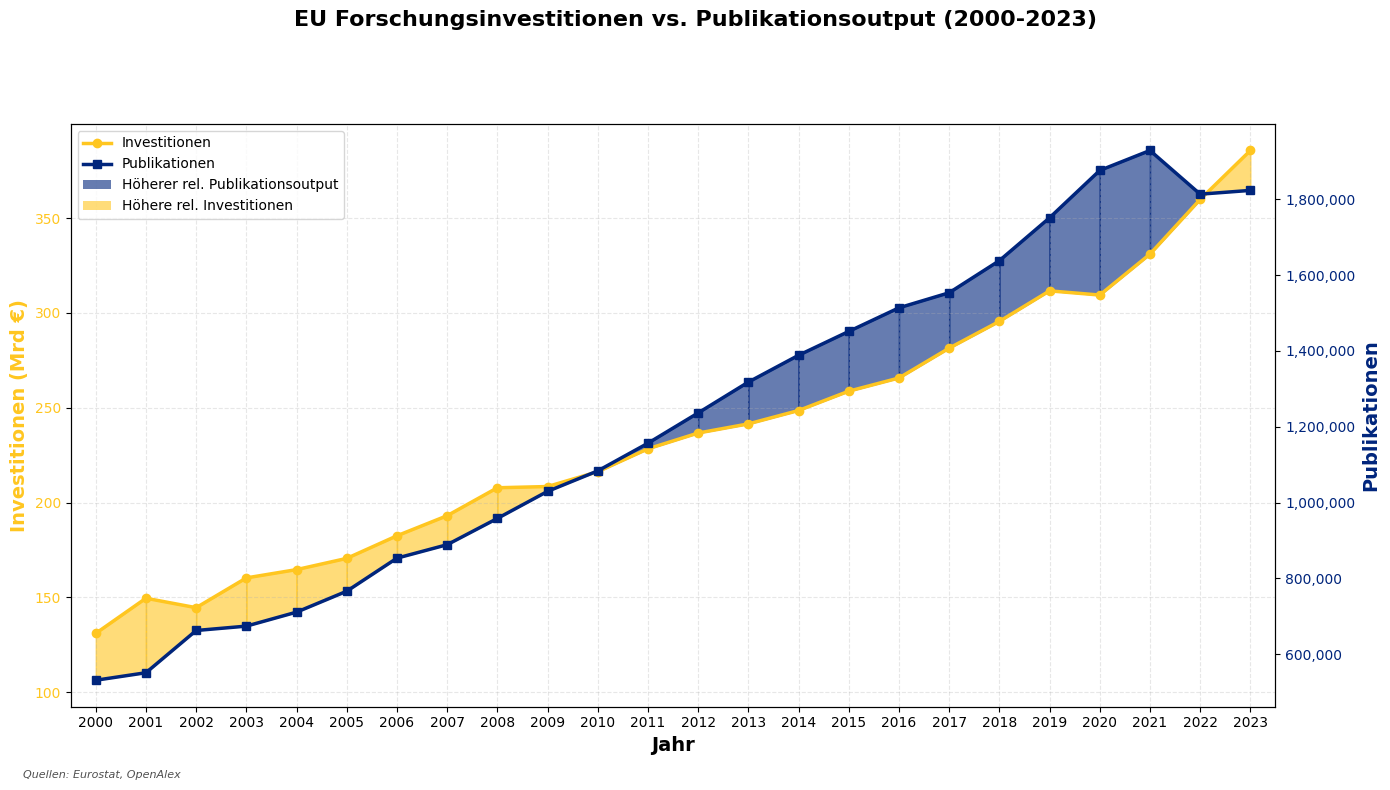

In [58]:
# Visualisierungs Designeinstellungen
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.family"] = "sans-serif"

fig, ax1 = plt.subplots(figsize=(14, 8))

# Linke Y-Achse für Investitionen
ax1.set_xlabel("Jahr", fontsize=14, fontweight="bold")
ax1.set_ylabel(
    "Investitionen (Mrd €)",
    color=settings.COLORS_YELLOW,
    fontsize=settings.CHART_FONTSIZE_AXIS,
    fontweight="bold",
)
ax1.plot(
    df["Jahr"],
    df["Investitionen_Mrd"],
    "-o",
    linewidth=2.5,
    color="#FFC620",
    markersize=6,
    label="Investitionen",
)
ax1.tick_params(axis="y", labelcolor="#FFC620")
ax1.grid(True, linestyle="--", alpha=0.3)

# Rechte Y-Achse für Publikationen
ax2 = ax1.twinx()
ax2.set_ylabel(
    "Publikationen",
    color=settings.COLORS_BLUE,
    fontsize=settings.CHART_FONTSIZE_AXIS,
    fontweight="bold",
)
ax2.plot(
    df["Jahr"],
    df["Anzahl_Paper"],
    "-s",
    linewidth=2.5,
    color="#00257C",
    markersize=6,
    label="Publikationen",
)
ax2.tick_params(axis="y", labelcolor=settings.COLORS_BLUE)
ax2.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Layoutkonfiguration
plt.xticks(df["Jahr"])
ax1.set_xlim(df["Jahr"].min() - 0.5, df["Jahr"].max() + 0.5)
plt.suptitle(
    f'EU Forschungsinvestitionen vs. Publikationsoutput ({df["Jahr"].min():.0f}-{df["Jahr"].max():.0f})',
    fontsize=16,
    fontweight="bold",
)
plt.figtext(
    0.02,
    0.02,
    "Quellen: Eurostat, OpenAlex",
    fontsize=8,
    fontstyle="italic",
    color=settings.COLORS_FOOTER,
)

# Farbige Flächeneinfärbung zwischen den normalisierten Kurven
norm_invest = df["Investitionen_Mrd"] / df["Investitionen_Mrd"].max()
norm_publik = df["Anzahl_Paper"] / df["Anzahl_Paper"].max()

for i in range(len(df) - 1):
    x_vals = [
        df["Jahr"].iloc[i], 
        df["Jahr"].iloc[i + 1]
    ]
    y1_vals = [
        df["Investitionen_Mrd"].iloc[i], 
        df["Investitionen_Mrd"].iloc[i + 1]
    ]
    y2_norm = [
        norm_publik.iloc[i] / norm_invest.iloc[i] * y1_vals[0],
        norm_publik.iloc[i + 1] / norm_invest.iloc[i + 1] * y1_vals[1],
    ]

    diff = np.mean(
        [
            (norm_publik.iloc[i] - norm_invest.iloc[i]),
            (norm_publik.iloc[i + 1] - norm_invest.iloc[i + 1]),
        ]
    )

    color = settings.COLORS_BLUE if diff > 0 else settings.COLORS_YELLOW
    ax1.fill_between(x_vals, y1_vals, y2_norm, color=color, alpha=0.6, zorder=1)

# Legende mit Flächenfarben
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

green_patch = Patch(
    facecolor="#00257C", alpha=0.6, label="Höherer rel. Publikationsoutput"
)
orange_patch = Patch(facecolor=settings.COLORS_YELLOW, alpha=0.6, label="Höhere rel. Investitionen")

ax1.legend(
    lines1 + lines2 + [green_patch, orange_patch],
    labels1 + labels2 + ["Höherer rel. Publikationsoutput", "Höhere rel. Investitionen"],
    loc="upper left",
)

plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.savefig("data/output/Hypothese_1.svg", format="svg", bbox_inches="tight")
plt.show()

## Statistische Analyse

### Deskriptive Statistik

In [59]:
print("Datengrundlage:")
print(f"    Anzahl Jahre: {len(df)}")
print(f"    Zeitraum: {df['Jahr'].min():.0f} - {df['Jahr'].max():.0f}")

Datengrundlage:
    Anzahl Jahre: 24
    Zeitraum: 2000 - 2023


In [60]:
print("Investitionen (Mrd €):")
print(f"    Mittelwert: {df['Investitionen_Mrd'].mean():.2f}")
print(f"    Median: {df['Investitionen_Mrd'].median():.2f}")
print(f"    Standardabweichung: {df['Investitionen_Mrd'].std():.2f}")
print(f"    Min: {df['Investitionen_Mrd'].min():.2f}")
print(f"    Max: {df['Investitionen_Mrd'].max():.2f}")
print(f"    Variationskoeffizient: {(df['Investitionen_Mrd'].std() / df['Investitionen_Mrd'].mean() * 100):.1f}%")

Investitionen (Mrd €):
    Mittelwert: 236.78
    Median: 232.51
    Standardabweichung: 70.33
    Min: 131.00
    Max: 385.69
    Variationskoeffizient: 29.7%


In [61]:
print("Publikationen:")
print(f"    Mittelwert: {df['Anzahl_Paper'].mean():.0f}")
print(f"    Median: {df['Anzahl_Paper'].median():.0f}")
print(f"    Standardabweichung: {df['Anzahl_Paper'].std():.0f}")
print(f"    Min: {df['Anzahl_Paper'].min():.0f}")
print(f"    Max: {df['Anzahl_Paper'].max():.0f}")
print(f"    Variationskoeffizient: {(df['Anzahl_Paper'].std() / df['Anzahl_Paper'].mean() * 100):.1f}%")

Publikationen:
    Mittelwert: 1215020
    Median: 1196584
    Standardabweichung: 454931
    Min: 531528
    Max: 1928659
    Variationskoeffizient: 37.4%


### Korrelationsanalyse

In [62]:
# Interpretation der Korrelationsstärke
def interpret_correlation(r):
    abs_r = abs(r)
    if abs_r < 0.1:
        return "Vernachlässigbar"
    elif abs_r < 0.3:
        return "Schwach"
    elif abs_r < 0.5:
        return "Moderat"
    elif abs_r < 0.7:
        return "Stark"
    else:
        return "Sehr stark"
    
def interpret_significance(p):
    if p < 0.05:
        return "Signifikant"
    else:
        return "Nicht signifikant"

In [63]:
# Pearson-Korrelation
pearson_corr, pearson_p = stats.pearsonr(df['Investitionen_Mrd'], df['Anzahl_Paper'])
print(f"Pearson-Korrelation: r = {pearson_corr:.4f}")
print(f"P-Wert (Pearson): {pearson_p:.6f}")
print(f"Signifikanz (α=0.05): {interpret_significance(pearson_p)}")

Pearson-Korrelation: r = 0.9708
P-Wert (Pearson): 0.000000
Signifikanz (α=0.05): Signifikant


In [64]:
# Spearman-Korrelation (rang-basiert, robuster)
spearman_corr, spearman_p = stats.spearmanr(df['Investitionen_Mrd'], df['Anzahl_Paper'])
print(f"Spearman-Korrelation: ρ = {spearman_corr:.4f}")
print(f"P-Wert (Spearman): {spearman_p:.6f}")
print(f"Signifikanz (α=0.05): {interpret_significance(spearman_p)}")

Spearman-Korrelation: ρ = 0.9896
P-Wert (Spearman): 0.000000
Signifikanz (α=0.05): Signifikant


In [65]:
print(f"Korrelationsstärke (Pearson): {interpret_correlation(pearson_corr)}")
print(f"Korrelationsstärke (Spearman): {interpret_correlation(spearman_corr)}")

Korrelationsstärke (Pearson): Sehr stark
Korrelationsstärke (Spearman): Sehr stark


### Regressionsanalyse

In [66]:
# Einfache lineare Regression
X = df['Investitionen_Mrd'].values.reshape(-1, 1)
y = df['Anzahl_Paper'].values

# Konstante hinzufügen für den Intercept
X_fit = sm.add_constant(X)

model = sm.OLS(y, X_fit)
results = model.fit()
display(results.summary())


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     359.7
Date:                Wed, 09 Jul 2025   Prob (F-statistic):           4.03e-15
Time:                        14:21:22   Log-Likelihood:                -311.97
No. Observations:                  24   AIC:                             627.9
Df Residuals:                      22   BIC:                             630.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.718e+05   8.16e+04     -3.329      0.003   -4.41e+05   -1.02e+05
x1          6279.2413    331.089     18.965      0.000    5592.605    6965.878
==============================================================================
Omnibus:                        8.566   Durbin-Watson:                   0.689
Prob(Omnibus):                  0.014   Jarque-Bera (JB):                6.700
Skew:                          -0.942   Prob(JB):                       0.0351
Kurtosis:                       4.774   Cond. No.                         883.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [67]:
# R-squared (Bestimmtheitsmaß)
r2 = results.rsquared
print(f"R² (Bestimmtheitsmaß): {r2:.4f}")
print(f"Erklärte Varianz: {r2*100:.1f}%")

R² (Bestimmtheitsmaß): 0.9424
Erklärte Varianz: 94.2%


In [68]:
# Regressionskoeffizienten
print(f"Achsenabschnitt (β₀): {results.params[0]:.2f}")
print(f"Steigung (β₁): {results.params[1]:.2f}")
print(f"Interpretation: Pro 1 Mrd € mehr Investition → {results.params[1]:.0f} mehr Publikationen")

Achsenabschnitt (β₀): -271809.52
Steigung (β₁): 6279.24
Interpretation: Pro 1 Mrd € mehr Investition → 6279 mehr Publikationen


In [69]:
# Residuen-Analyse
residuals = results.resid
mse = np.mean(residuals**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(residuals))

print(f"Mittlerer quadratischer Fehler (MSE): {mse:.0f}")
print(f"Wurzel des mittleren quadratischen Fehlers (RMSE): {rmse:.0f}")
print(f"Mittlerer absoluter Fehler (MAE): {mae:.0f}")

Mittlerer quadratischer Fehler (MSE): 11432006273
Wurzel des mittleren quadratischen Fehlers (RMSE): 106921
Mittlerer absoluter Fehler (MAE): 78534


### Trend Analyse

In [70]:
# Zeittrend für Investitionen
years = df['Jahr'].values
inv_slope, inv_intercept, inv_r, inv_p, inv_stderr = stats.linregress(years, df['Investitionen_Mrd'])
print(f"Investitionstrend:")
print(f"    Jährliche Änderung: {inv_slope:.3f} Mrd €/Jahr")
print(f"    R²: {inv_r**2:.4f}")
print(f"    P-Wert: {inv_p:.6f}")
print(f"    Trend: {'Signifikant steigend' if inv_p < 0.05 and inv_slope > 0 else 'Signifikant fallend' if inv_p < 0.05 and inv_slope < 0 else 'Kein signifikanter Trend'}")

Investitionstrend:
    Jährliche Änderung: 9.812 Mrd €/Jahr
    R²: 0.9732
    P-Wert: 0.000000
    Trend: Signifikant steigend


In [71]:
# Zeittrend für Publikationen
pub_slope, pub_intercept, pub_r, pub_p, pub_stderr = stats.linregress(years, df['Anzahl_Paper'])
print(f"Publikationstrend:")
print(f"    Jährliche Änderung: {pub_slope:.0f} Publikationen/Jahr")
print(f"    R²: {pub_r**2:.4f}")
print(f"    P-Wert: {pub_p:.6f}")
print(f"    Trend: {'Signifikant steigend' if pub_p < 0.05 and pub_slope > 0 else 'Signifikant fallend' if pub_p < 0.05 and pub_slope < 0 else 'Kein signifikanter Trend'}")

Publikationstrend:
    Jährliche Änderung: 63908 Publikationen/Jahr
    R²: 0.9867
    P-Wert: 0.000000
    Trend: Signifikant steigend


### Effizienzkennzahlen

In [72]:
df_analysis = df.copy(deep=True)

In [73]:
# Publikationen pro Milliarde Euro
df_analysis['Pub_pro_Mrd'] = df_analysis['Anzahl_Paper'] / df_analysis['Investitionen_Mrd']

print(f"Publikationen pro Mrd € Investition:")
print(f"    Mittelwert: {df_analysis['Pub_pro_Mrd'].mean():.0f}")
print(f"    Median: {df_analysis['Pub_pro_Mrd'].median():.0f}")
print(f"    Standardabweichung: {df_analysis['Pub_pro_Mrd'].std():.0f}")
print(f"    Min: {df_analysis['Pub_pro_Mrd'].min():.0f} (Jahr {df_analysis.loc[df_analysis['Pub_pro_Mrd'].idxmin(), 'Jahr']:.0f})")
print(f"    Max: {df_analysis['Pub_pro_Mrd'].max():.0f} (Jahr {df_analysis.loc[df_analysis['Pub_pro_Mrd'].idxmax(), 'Jahr']:.0f})")

Publikationen pro Mrd € Investition:
    Mittelwert: 5007
    Median: 5025
    Standardabweichung: 620
    Min: 3687 (Jahr 2001)
    Max: 6063 (Jahr 2020)


In [74]:
# Wachstumsraten
df_analysis['Inv_growth'] = df_analysis['Investitionen_Mrd'].pct_change() * 100
df_analysis['Pub_growth'] = df_analysis['Anzahl_Paper'].pct_change() * 100

print(f"Durchschnittliche jährliche Wachstumsraten:")
print(f"    Investitionen: {df_analysis['Inv_growth'].mean():.1f}% ± {df_analysis['Inv_growth'].std():.1f}%")
print(f"    Publikationen: {df_analysis['Pub_growth'].mean():.1f}% ± {df_analysis['Pub_growth'].std():.1f}%")

Durchschnittliche jährliche Wachstumsraten:
    Investitionen: 4.9% ± 3.7%
    Publikationen: 5.6% ± 4.6%


In [75]:
# Korrelation der Wachstumsraten
growth_corr, growth_p = stats.pearsonr(df_analysis['Inv_growth'].dropna(), df_analysis['Pub_growth'].dropna())
print(f"Korrelation der Wachstumsraten: r = {growth_corr:.4f} | p = {growth_p:.4f}")

Korrelation der Wachstumsraten: r = -0.5975 | p = 0.0026


### Zusätzliche Tests

In [76]:
# Shapiro-Wilk Test für Normalverteilung
shapiro_inv = stats.shapiro(df['Investitionen_Mrd'])
shapiro_pub = stats.shapiro(df['Anzahl_Paper'])

print(f"Normalverteilungstest (Shapiro-Wilk):")
print(f"    Investitionen: W = {shapiro_inv.statistic:.4f} | p = {shapiro_inv.pvalue:.6f}")
print(f"    Publikationen: W = {shapiro_pub.statistic:.4f} | p = {shapiro_pub.pvalue:.6f}")
print(f"    Normalverteilt (α=0.05): Inv: {'Ja' if shapiro_inv.pvalue > 0.05 else 'Nein'}, Pub: {'Ja' if shapiro_pub.pvalue > 0.05 else 'Nein'}")

Normalverteilungstest (Shapiro-Wilk):
    Investitionen: W = 0.9669 | p = 0.590850
    Publikationen: W = 0.9393 | p = 0.157022
    Normalverteilt (α=0.05): Inv: Ja, Pub: Ja


In [77]:
# Jarque-Bera Test (alternative für Normalverteilung)
if len(df) >= 8:  # Mindestanforderung für Jarque-Bera
    from scipy.stats import jarque_bera
    jb_inv = jarque_bera(df['Investitionen_Mrd'])
    jb_pub = jarque_bera(df['Anzahl_Paper'])
    print(f"Jarque-Bera Test:")
    print(f"    Investitionen: JB = {jb_inv.statistic:.4f} | p = {jb_inv.pvalue:.6f}")
    print(f"    Publikationen: JB = {jb_pub.statistic:.4f} | p = {jb_pub.pvalue:.6f}")

Jarque-Bera Test:
    Investitionen: JB = 1.1496 | p = 0.562828
    Publikationen: JB = 1.7621 | p = 0.414357


### Zusammenfassung

In [78]:
print(f"Korrelation: {pearson_corr:.3f} ({'stark' if abs(pearson_corr) > 0.7 else 'moderat' if abs(pearson_corr) > 0.5 else 'schwach'})")
print(f"Bestimmtheitsmaß: {r2:.3f} ({r2*100:.1f}% erklärte Varianz)")
print(f"Investitionstrend: {inv_slope:.3f} Mrd €/Jahr ({'↗' if inv_slope > 0 else '↘'})")
print(f"Publikationstrend: {pub_slope:.0f} Papers/Jahr ({'↗' if pub_slope > 0 else '↘'})")
print(f"Durchschnittliche Effizienz: {df_analysis['Pub_pro_Mrd'].mean():.0f} Publikationen/Mrd €")

Korrelation: 0.971 (stark)
Bestimmtheitsmaß: 0.942 (94.2% erklärte Varianz)
Investitionstrend: 9.812 Mrd €/Jahr (↗)
Publikationstrend: 63908 Papers/Jahr (↗)
Durchschnittliche Effizienz: 5007 Publikationen/Mrd €
